# Imports

In [ ]:
!pip install unidecode
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download pl_core_news_lg
!pip install -q -U keras-tuner
!pip install '/content/drive/MyDrive/NLP ICM/morfeusz2-1.99.5-20220529-cp310.cp35.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.6/573.6 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/NLP ICM/morfeusz2-1.99.5-20220529-cp310.cp35.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl
morfeusz2 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [ ]:
import pandas as pd
import numpy as n
import re
from unidecode import unidecode

import nltk
nltk.download('punkt')

import spacy
nlp = spacy.load("pl_core_news_lg")

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras_tuner as kt

import matplotlib.pyplot as plt

import morfeusz2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Data preprocessing

In [ ]:
# importing polish stopwords from file and from spacy library
stopwordsPath = "/content/drive/MyDrive/NLP ICM/polish_stopwords.txt"
with open(stopwordsPath, "r") as f:
  stopwordsLocal = set([re.sub("\s+", "", x) for x in f])

morf = morfeusz2.Morfeusz()

# preprocessing function

def process(sentence):
  sentenceTemp = sentence
  stopwords = set(nlp.Defaults.stop_words).union(stopwordsLocal)

  sentenceTemp = re.sub(r"e.?mail", "email", sentenceTemp)
  sentenceTemp = re.sub(r"Sp\. ?z ?o\.o\.", "spółka", sentenceTemp)
  sentenceTemp = re.sub(r"ust\.", "ustawa", sentenceTemp)

  # analysis of word using Morfeusz library and encoding to unicode
  temp = []
  for word in sentenceTemp.split():
    analysis = morf.analyse(word)
    temp.append(unidecode(analysis[0][2][1]))
  
  sentenceTemp = " ".join(temp)

  # changing data left from Morfeusz analysis - <word>:asda... to <word>
  sentenceTemp = re.sub(":[^ ]*", "", sentenceTemp)

  # punctuation removal
  sentenceTemp = re.sub(r"[^\w\s]", " ", sentenceTemp)

  # numbers deletion
  sentenceTemp = re.sub(r"\w*\d\w*", "", sentenceTemp)

  # whitespace characters deletion
  sentenceTemp = re.sub("\s+", " ", sentenceTemp)

  # multiple spaces removal
  sentenceTemp = re.sub(r"[ +]", " ", sentenceTemp)

  # striping and lowering of letters
  temp = []
  for word in sentenceTemp.split():
    if word.lower() not in stopwords:
      temp.append(word.lower().strip())
  
  sentenceTemp = " ".join(temp)

  return sentenceTemp

In [ ]:
# loading train and test data
dataPath = "/content/drive/MyDrive/NLP ICM/dane treningowe_I etap.csv"
data = pd.read_csv(dataPath)

X = data["text"].to_numpy()
Y = data["class"].to_numpy()

# data processing and saving it to list
X_processed = [process(x) for x in X]
Y_processed = [1 if y=="KLAUZULA_ABUZYWNA" else 0 for y in Y]


labels = {
    1: "KLAUZULA_ABUZYWNA",
    0: "BEZPIECZNA_KLAUZULA"
}

In [ ]:
# randomly dividing to train and test set
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_processed, test_size=test_size)

# dividing to validation set (test) and test (test__)
X_test, X_test__, y_test, y_test__ = train_test_split(X_test, y_test, test_size=0.25)

# example of processed
for x, processed_x in zip(X[:15], X_processed[:15]):
  print(f"Before: {x}")
  print(f"After processing: {processed_x}")
  print()


Before: Wszelka korespondencja wysyłana przez Pożyczkodawcę na adres zamieszkania podany w umowie oraz na e-mail zostaje uznana za skutecznie doręczoną. Zmiana adresu e-mail oraz adresu zamieszkania musi być dostarczona do Pożyczkodawcy osobiście
After processing: wszelki korespondencja wysylac pozyczkodawca adres zamieszkac podac umowa email zostawac uznac skutecznie doreczyc zmiana adres email adres zamieszkac muszy dostarczyc pozyczkodawca osobiscie

Before: W przypadku opóźnień Pożyczkobiorcy w spłacie pożyczki Pożyczkodawca ma prawo raz dziennie telefonicznie upomnieć Pożyczkobiorcę do spłaty pożyczki. Za każdy telefon do Pożyczkobiorcy Pożyczkodawca nalicza opłatę w wysokości 100
After processing: przypadek opoznienie pozyczkobiorca splat pozyczka pozyczkodawca miec prawo dziennie telefonicznie upomniec pozyczkobiorca splat pozyczka telefon pozyczkobiorca pozyczkodawca naliczac oplata wysokosc

Before: W przypadku opóźnień Pożyczkobiorcy w spłacie pożyczki Pożyczkodawca ma prawo 

# Neural Network Creation


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset__ = tf.data.Dataset.from_tensor_slices((X_test__, y_test__))

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'dzien opoznienie zaplata oplata szkola pobierac odsetka wysokosc odsetek ustawowy opoznic oda dzien wymagalnosc zaplata dzien zaplata'
label:  0


In [ ]:
BATCH_SIZE = 64

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset__ = test_dataset__.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'dzien opoznienie zaplata oplata szkola pobierac odsetka wysokosc odsetek ustawowy opoznic oda dzien wymagalnosc zaplata dzien zaplata'
 b'termin zachowac odeslac panstwo rzecz uplyw termin dzien panstwo musiec poniesc bezposredni koszt zwrot towar'
 b'd dzialalnosc gospodarczy szkola dzialalnosc zostac podjac e pozalekcyjny dzialalnosc szkola nadobowiazkowy']

labels:  [0 0 0]


In [ ]:
# encoder creation
VOCAB_SIZE = 2000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()
  
  model.add(encoder)

  hp_vector_dim = hp.Fixed('embedding_dim', value=128)

  model.add(tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=hp_vector_dim,
        mask_zero=True))

  # Tune LSTM layer
  hp_units_LSTM = hp.Fixed('units_LSTM', value=64)
  hp_dropout = hp.Fixed('dropout_LSTM', value=0.2)
  hp_L2 = hp.Fixed('L2_LSTM', value=0.001)
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hp_units_LSTM, 
                                                               kernel_regularizer=tf.keras.regularizers.L2(hp_L2)
                                                               )))

  # Tune Dense layer
  hp_units_DENSE = hp.Fixed('units_DENSE', value=16)
  hp_L2_dense = hp.Fixed('L2_DENSE', value=0.001)
  model.add(tf.keras.layers.Dense(units=hp_units_DENSE, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.L2(hp_L2_dense)
                                  ))

  # Last layer
  model.add(tf.keras.layers.Dense(1))

  # Tune learning rate
  hp_learning_rate = hp.Fixed('learning_rate', value=1e-3)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=["accuracy"])

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/NLP ICM/HPTuning',
                     project_name='NLP_ICM_L2_11')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
                                              
tuner.search(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/NLP ICM/HPTuning/NLP_ICM_L2_11/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/NLP ICM/HPTuning/NLP_ICM_L2_11/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=len(X_test)//BATCH_SIZE,
                    batch_size=64)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/10
54/54 [==============================] - 21s 81ms/step - loss: 0.8234 - accuracy: 0.5827 - val_loss: 0.5841 - val_accuracy: 0.7766
Epoch 2/10
54/54 [==============================] - 2s 30ms/step - loss: 0.4604 - accuracy: 0.8240 - val_loss: 0.4476 - val_accuracy: 0.8078
Epoch 3/10
54/54 [==============================] - 2s 31ms/step - loss: 0.3268 - accuracy: 0.8830 - val_loss: 0.4466 - val_accuracy: 0.8234
Epoch 4/10
54/54 [==============================] - 2s 31ms/step - loss: 0.2494 - accuracy: 0.9186 - val_loss: 0.5609 - val_accuracy: 0.8219
Epoch 5/10
54/54 [==============================] - 2s 31ms/step - loss: 0.2019 - accuracy: 0.9405 - val_loss: 0.6231 - val_accuracy: 0.8219
Epoch 6/10
54/54 [==============================] - 2s 32ms/step - loss: 0.1768 - accuracy: 0.9521 - val_loss: 0.5676 - val_accuracy: 0.8297
Epoch 7/10
54/54 [==============================] - 2s 30ms/step - loss: 0.1642 - accuracy: 0.9603 - val_loss: 0.4763 - val_accuracy: 0.8422
Epoch 8/10
5

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(train_dataset, epochs=best_epoch,
                    validation_data=test_dataset,
                    validation_steps=len(X_test)//BATCH_SIZE,
                    batch_size=64)

Epoch 1/7
54/54 [==============================] - 15s 132ms/step - loss: 0.8186 - accuracy: 0.6198 - val_loss: 0.5638 - val_accuracy: 0.7953
Epoch 2/7
54/54 [==============================] - 3s 55ms/step - loss: 0.4483 - accuracy: 0.8316 - val_loss: 0.4515 - val_accuracy: 0.8219
Epoch 3/7
54/54 [==============================] - 2s 45ms/step - loss: 0.3160 - accuracy: 0.8885 - val_loss: 0.4805 - val_accuracy: 0.8234
Epoch 4/7
54/54 [==============================] - 3s 55ms/step - loss: 0.2576 - accuracy: 0.9136 - val_loss: 0.4808 - val_accuracy: 0.8250
Epoch 5/7
54/54 [==============================] - 3s 53ms/step - loss: 0.2098 - accuracy: 0.9343 - val_loss: 0.5365 - val_accuracy: 0.8156
Epoch 6/7
54/54 [==============================] - 2s 30ms/step - loss: 0.1646 - accuracy: 0.9562 - val_loss: 0.5086 - val_accuracy: 0.8328
Epoch 7/7
54/54 [==============================] - 2s 30ms/step - loss: 0.1378 - accuracy: 0.9682 - val_loss: 0.4944 - val_accuracy: 0.8344


In [ ]:
test_loss, test_acc = hypermodel.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

11/11 [==============================] - 0s 10ms/step - loss: 0.4930 - accuracy: 0.8349
Test Loss: 0.49298372864723206
Test Accuracy: 0.8348909616470337


(0.0, 0.852649686485529)

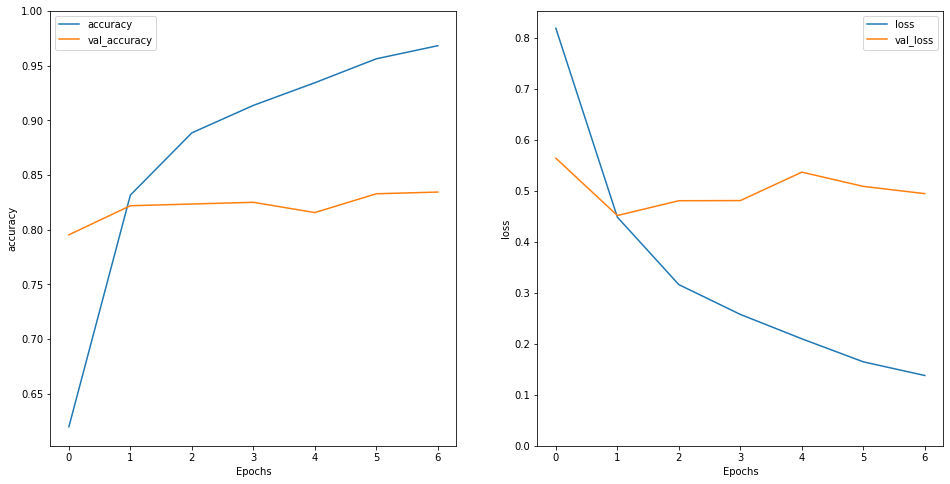

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Model evaluation

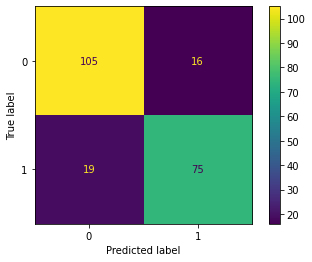

F1 score: 0.811
Accuracy score: 0.837
auc: 0.833


In [ ]:
test_predict = hypermodel.predict(test_dataset__)
prediction = [1 if x > 0.5 else 0 for x in tf.sigmoid(test_predict)]

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc

F1 = f1_score(y_test__, prediction)
acc = accuracy_score(y_test__, prediction)
cf_matrix = confusion_matrix(y_test__, prediction)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test__, prediction)
auc_keras = auc(fpr_keras, tpr_keras)

ConfusionMatrixDisplay.from_predictions(y_test__, prediction)
plt.show()
print(f"F1 score: {F1:.3f}")
print(f"Accuracy score: {acc:.3f}")
print(f"auc: {auc_keras:.3f}")

# Model evaluation with testing data from GovTech website

In [ ]:
# loading more test data
dataPath = "/content/drive/MyDrive/NLP ICM/dane testowe z klasami_I etap.csv"
data = pd.read_csv(dataPath)

X_TEST = data["text"].to_numpy()
Y_TEST = data["class"].to_numpy()

# data processing and saving it to list
X_TEST_processed = [process(x) for x in X]
Y_TEST_processed = [1 if y=="KLAUZULA_ABUZYWNA" else 0 for y in Y]

TEST_DATASET = tf.data.Dataset.from_tensor_slices((X_TEST_processed, Y_TEST_processed))
TEST_DATASET = TEST_DATASET.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_predict = hypermodel.predict(TEST_DATASET)
prediction = [1 if x > 0.5 else 0 for x in tf.sigmoid(test_predict)]

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

F1 = f1_score(Y_TEST_processed, prediction)
acc = accuracy_score(Y_TEST_processed, prediction)
cf_matrix = confusion_matrix(Y_TEST_processed, prediction)

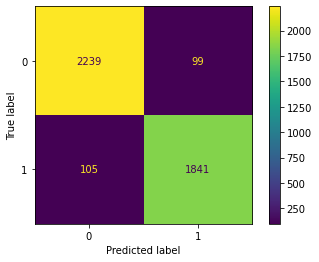

F1 score: 0.948
Accuracy score: 0.952


In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_TEST_processed, prediction)
plt.show()
print(f"F1 score: {F1:.3f}")
print(f"Accuracy score: {acc:.3f}")